In [1]:
import os
import numpy as np
import json
import argparse
import torch
from matplotlib import pyplot as plt

import config
from GPT import GPT
from StimulusModel import LMFeatures
from utils_stim import get_stim
from utils_resp import get_resp
from utils_ridge.ridge import ridge, bootstrap_ridge

/chronos_data/rrao/conda/envs/thought2text/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/chronos_data/rrao/conda/envs/thought2text/lib/python3.10/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
/chronos_data/rrao/conda/envs/thought2text/lib/python3.10/site-packages/torch/__init__.py:747: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /opt/conda/conda-bld/pytorch_1712608839953/work/torch/csrc/tensor/python_tensor.cpp:431.)
  _C._set_default_tensor_type(t)


In [2]:
def f(x, y):
    return np.sin(np.sqrt(x ** 2 + y ** 2))

x = np.linspace(-6, 6, 30)
y = np.linspace(-6, 6, 30)

X, Y = np.meshgrid(x, y)
Z = f(X, Y)

In [5]:
print(x.shape)
print(y.shape)
print(Z.shape)

(30,)
(30,)
(30, 30)


In [2]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
np.random.seed(42)

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument("--subject", type = str, default = "S1")
parser.add_argument("--gpt", type = str, default = "perceived", choices=["perceived", "imagined"])
parser.add_argument("--sessions", nargs = "+", type = int, 
    default = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 18, 20])
parser.add_argument("--model", type = str, default = "EM", choices=["EM", "EM_MLP", "EM_GPT2"])
parser.add_argument("--plot_name", type = str, default="", help="Specify a filename to save the plot (leave empty if not to save)")
args = parser.parse_args("--subject S1".split())

In [4]:
# training stories
stories = []
with open(os.path.join(config.DATA_TRAIN_DIR, "sess_to_story.json"), "r") as f:
    sess_to_story = json.load(f)
for sess in args.sessions:
    stories.extend(sess_to_story[str(sess)])

In [5]:
# load gpt
with open(os.path.join(config.DATA_LM_DIR, args.gpt, "vocab.json"), "r") as f:
    gpt_vocab = json.load(f)
gpt = GPT(path = os.path.join(config.DATA_LM_DIR, args.gpt, "model"), vocab = gpt_vocab, device = config.GPT_DEVICE)
features = LMFeatures(model = gpt, layer = config.GPT_LAYER, context_words = config.GPT_WORDS)

In [6]:
# load text stimulus
rstim, tr_stats, word_stats = get_stim(stories, features)
rstim = torch.from_numpy(rstim).float().to(DEVICE)
# load fmri responses
rresp = get_resp(args.subject, stories, stack = True)
rresp = torch.from_numpy(rresp).float().to(DEVICE)

In [7]:
# load EM weights
load_location = os.path.join(config.MODEL_DIR, args.subject)
encoding_model = np.load(os.path.join(load_location, "encoding_model_%s.npz" % args.gpt))
weights = torch.from_numpy(encoding_model["weights"]).float().to(DEVICE)

In [16]:
# make response predictions
presp = torch.matmul(rstim, weights) * 10
res = torch.square(presp - rresp)

In [17]:
# compute overall mse (voxel-wise)
mse_per_sample  = torch.mean(res, dim=1)
overall_mse = torch.mean(mse_per_sample)
print("Overall MSE (voxel-wise):", overall_mse.item())

Overall MSE (voxel-wise): 1.3242875337600708


In [18]:
print(torch.min(rresp))
print(torch.max(rresp))
print(torch.min(presp))
print(torch.max(presp))

tensor(-19.7124, device='cuda:0')
tensor(20.2909, device='cuda:0')
tensor(-19.2626, device='cuda:0')
tensor(21.5805, device='cuda:0')


In [19]:
print(rresp[0,0])
print(presp[0,0])

tensor(0.1185, device='cuda:0')
tensor(0., device='cuda:0')


In [23]:
avg_presp = torch.mean(presp, dim=0)
avg_rresp = torch.mean(rresp, dim=0)
avg_res = torch.mean(res, dim=0)

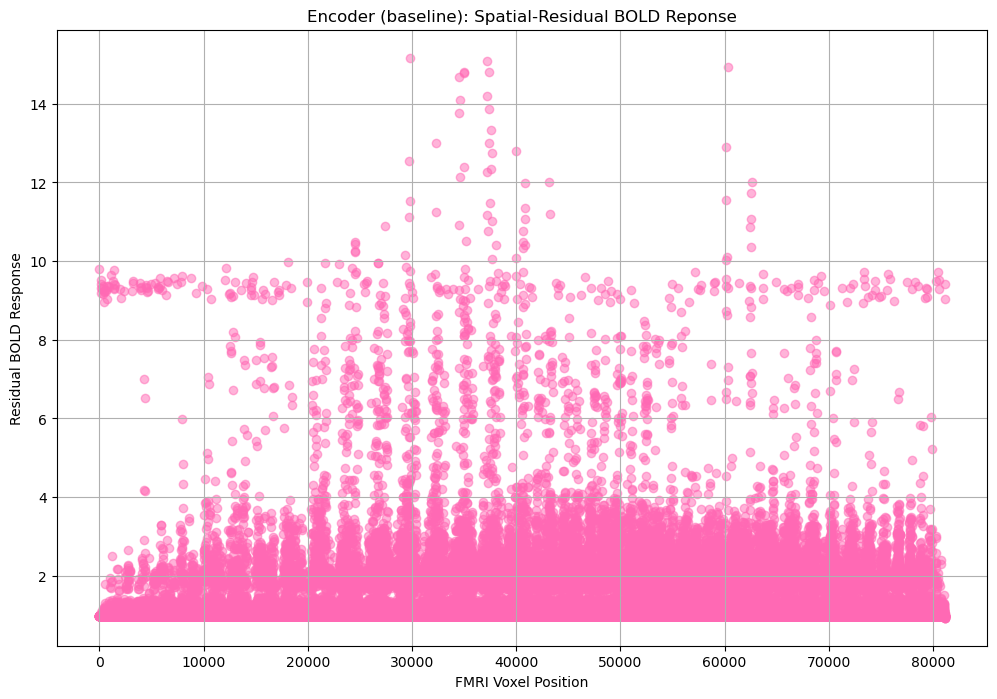

In [31]:
plt.figure(figsize=(12, 8))
plt.scatter(list(range(len(avg_res))), avg_res.cpu().numpy(), alpha=0.5, color="hotpink")
plt.xlabel("FMRI Voxel Position")
plt.ylabel("Residual BOLD Response")
plt.title("Encoder (baseline): Spatial-Residual BOLD Reponse")
plt.grid(True)
plt.show()

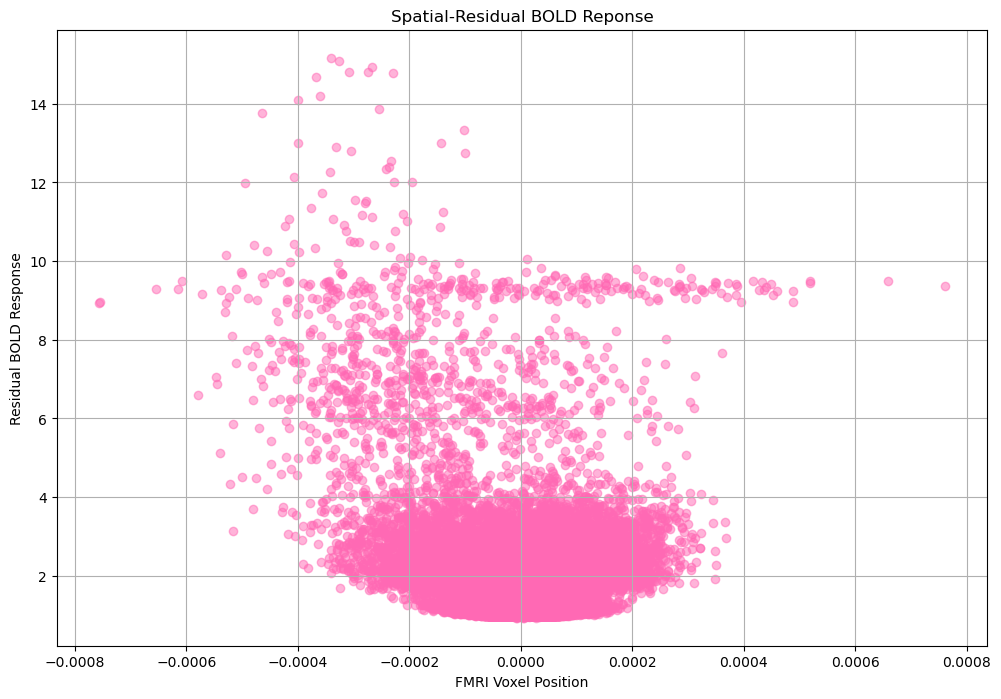

In [30]:
plt.figure(figsize=(12, 8))
plt.scatter(avg_presp.cpu().numpy(), avg_res.cpu().numpy(), alpha=0.5, color="hotpink")
plt.xlabel("FMRI Voxel Position")
plt.ylabel("Residual BOLD Response")
plt.title("Spatial-Residual BOLD Reponse")
plt.grid(True)
plt.show()